/tmp/ipykernel_44122/317768223.py:34: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  plt.title(classes[int(y_train[idx])])


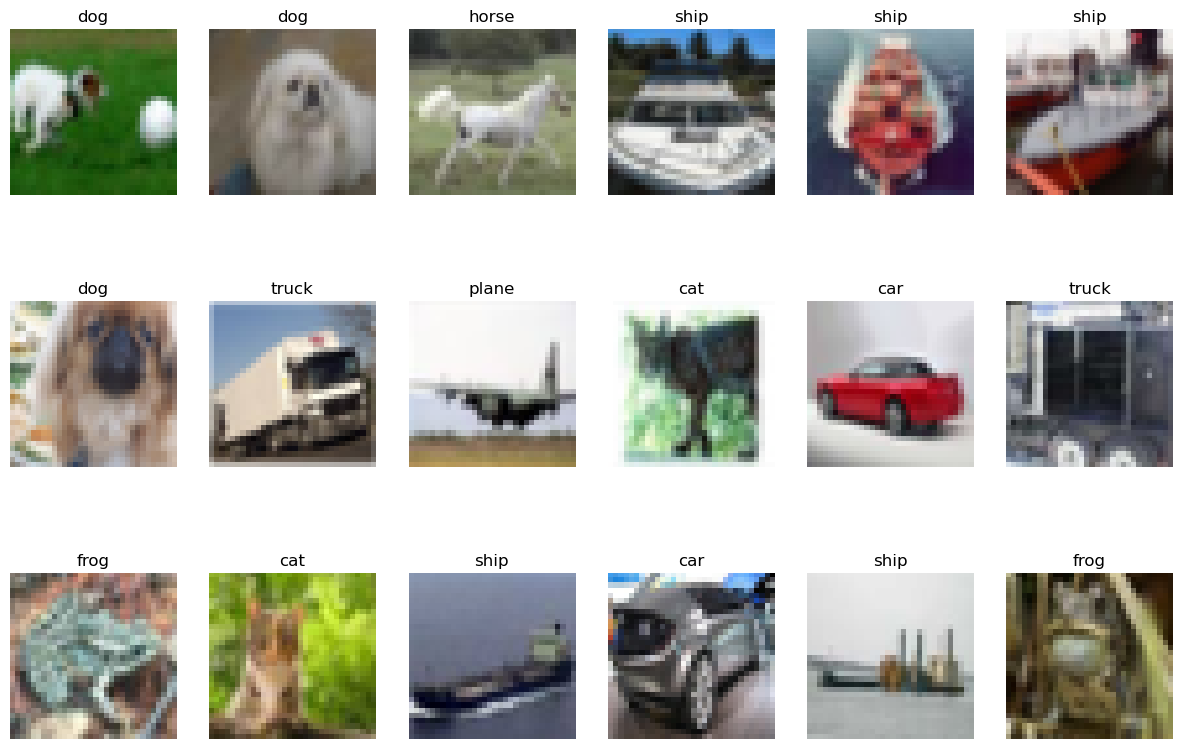

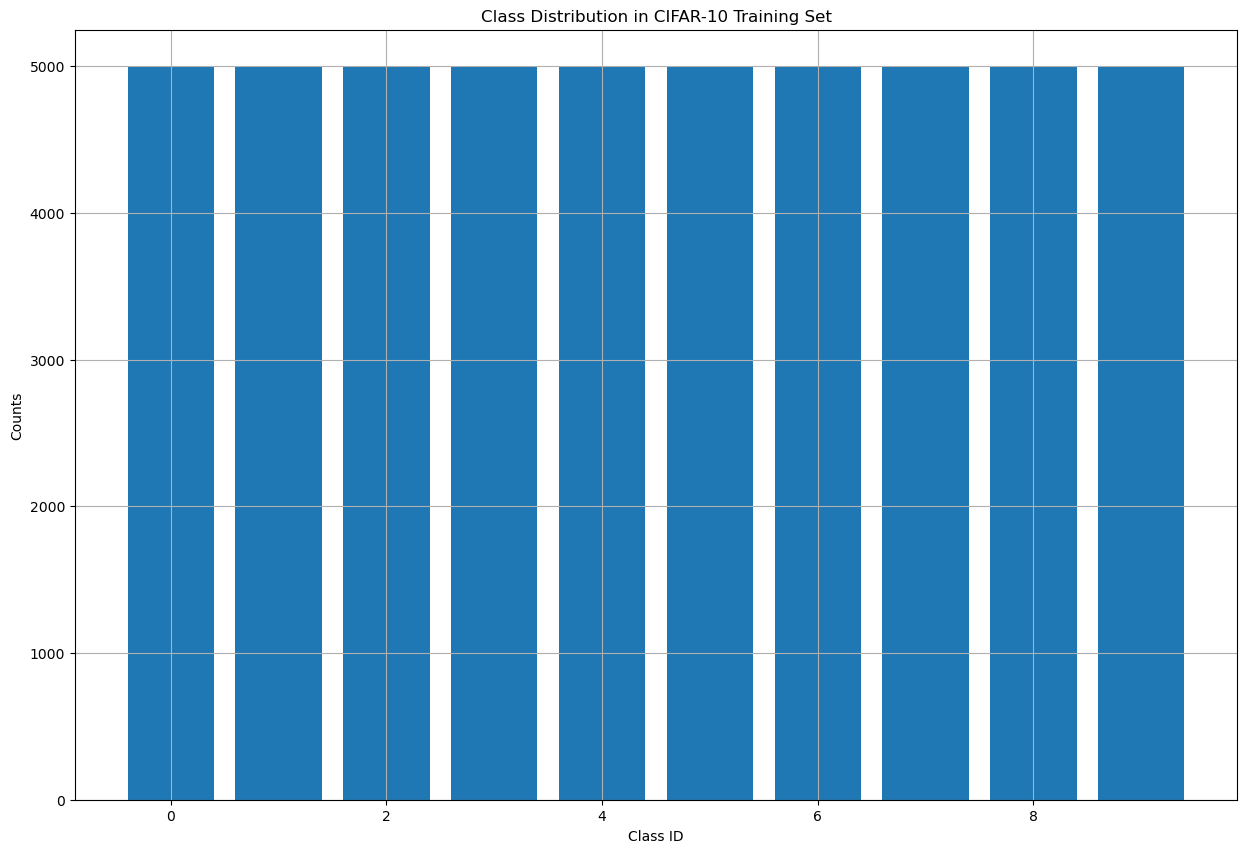

Train set:    50000 samples
Test set:     10000 samples
Sample dims:  (50000, 32, 32, 3)
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 4, 128)         73856     
______________________________________

AttributeError: module 'tensorflow.python.distribute.input_lib' has no attribute 'DistributedDatasetInterface'

In [3]:
import numpy as np
import tensorflow as tf
from tensorflow.python.keras.layers import Conv2D, Dense, Flatten, Input, MaxPooling2D
from tensorflow.python.keras import Model
from time import time

from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [15, 10]

# Set the seeds for reproducibility
from numpy.random import seed
from tensorflow.random import set_seed
seed_value = 1234578790
seed(seed_value)
set_seed(seed_value)

# Load the dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
# Mapping from class ID to class name
classes = {0: 'plane', 1: 'car', 2: 'bird', 3: 'cat', 4: 'deer',
           5: 'dog', 6: 'frog', 7: 'horse', 8: 'ship', 9: 'truck'}

# Dataset params
num_classes = len(classes)
size = x_train.shape[1]

# Visualize random samples (as a plot with 3x6 samples)
for ii in range(18):
    plt.subplot(3, 6, ii+1)
    # Pick a random sample
    idx = np.random.randint(0, x_train.shape[0])
    # Show the image and the label
    plt.imshow(x_train[idx, ...])
    plt.title(classes[int(y_train[idx])])
    plt.axis('off')

plt.show()

# Compute the class histogram
from collections import Counter

hist = Counter(y_train.flatten())
plt.bar(hist.keys(), hist.values())
plt.grid(True)
plt.xlabel('Class ID')
plt.ylabel('Counts')
plt.title('Class Distribution in CIFAR-10 Training Set')
plt.show()

# Normalization
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# One-hot encoding
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

print('Train set:   ', len(y_train), 'samples')
print('Test set:    ', len(y_test), 'samples')
print('Sample dims: ', x_train.shape)


# Build the classifier
inputs = Input(shape=(size, size, 3))
x = Conv2D(32, (3, 3), activation='relu')(inputs)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(128, (3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2))(x)
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
outputs = Dense(num_classes, activation='softmax')(x)

model = Model(inputs, outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Show the model
model.summary()


# Train the model
epochs = 25
batch_size = 128
history = model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2)

# Show training history
h = history.history
epochs_range = range(len(h['loss']))

plt.subplot(121)
plt.plot(epochs_range, h['loss'], '.-', epochs_range, h['val_loss'], '.-')
plt.grid(True)
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(['Train', 'Validation'])

plt.subplot(122)
plt.plot(epochs_range, h['accuracy'], '.-', epochs_range, h['val_accuracy'], '.-')
plt.grid(True)
plt.xlabel('epochs')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'])

print('Train Acc     ', h['accuracy'][-1])
print('Validation Acc', h['val_accuracy'][-1])


# Compute the labels and the predictions as sparse values
y_true = y_test.argmax(axis=1)
y_pred = model.predict(x_test).argmax(axis=-1)

# Compute and print the accuracy for each class
for class_id, class_name in classes.items():
    acc = np.mean(y_pred[y_true == class_id] == class_id)
    print(class_name, acc)

# Print the overall stats
ev = model.evaluate(x_test, y_test)
print('Test loss  ', ev[0])
print('Test metric', ev[1])

# Show random samples
for ii in range(15):
    # Pick a random sample
    idx = np.random.randint(0, x_test.shape[0])
    # Show the results
    plt.subplot(3, 5, ii+1)
    plt.imshow(x_test[idx, ...])
    plt.title('True: ' + str(classes[y_true[idx]]) + ' | Pred: ' + str(classes[y_pred[idx]]))
    plt.axis('off')

plt.show()

